In [46]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.log.util import sorting
from scipy.stats import wasserstein_distance
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from log_distance_measures.config import EventLogIDs, AbsoluteTimestampType, discretize_to_hour
from log_distance_measures.control_flow_log_distance import control_flow_log_distance
from log_distance_measures.n_gram_distribution import n_gram_distribution_distance
from log_distance_measures.absolute_event_distribution import absolute_event_distribution_distance
from log_distance_measures.case_arrival_distribution import case_arrival_distribution_distance
from log_distance_measures.circadian_event_distribution import circadian_event_distribution_distance
from log_distance_measures.relative_event_distribution import relative_event_distribution_distance
from log_distance_measures.work_in_progress import work_in_progress_distance
from log_distance_measures.cycle_time_distribution import cycle_time_distribution_distance

import warnings
warnings.filterwarnings("ignore")

In [47]:
import re
def extract_first_float(cell):
    if isinstance(cell, str):
        # Use regular expression to extract the first float and the value in brackets
        match = re.match(r'(\d+\.\d+)(?: \((\d+\.\d+)\))?', cell)
        if match:
            return float(match.group(1)), (match.group(2)) if match.group(2) else ''
        else:
            return float('inf'), ''
    else:
        return cell, ''

In [48]:
def highlight_min_max(s):
    """
    Highlight the minimum value in green and the maximum value in red for each column.
    """
    is_min = s == s.min()
    is_max = s == s.max()
    min_max_style = ['background-color: green' if v else '' for v in is_min]
    for i, v in enumerate(is_max):
        if v:
            min_max_style[i] = 'background-color: red'
    return min_max_style

In [49]:
def align_column_names(df):
    if 'case:concept:name' in df.columns:
        df = df.rename(columns={'case:concept:name': 'case_id'})
    elif 'caseid' in df.columns:
        df = df.rename(columns={'caseid': 'case_id'})
    if 'Activity' in df.columns:
        df = df.rename(columns={'Activity': 'activity'})
    elif 'activity_name' in df.columns:
        df = df.rename(columns={'activity_name': 'activity'})
    elif 'task' in df.columns:
        df = df.rename(columns={'task': 'activity'})
    elif 'concept:name' in df.columns:
        df = df.rename(columns={'concept:name': 'activity'})
    if 'Resource' in df.columns:
        df = df.rename(columns={'Resource': 'resource'})
    elif 'user' in df.columns:
        df = df.rename(columns={'user': 'resource'})
    # elif 'agent' in df.columns:
    #     if 'resource' in df.columns:
    #         df = df.drop(['resource'], axis=1)
    #     df = df.rename(columns={'agent': 'resource'})
    elif 'org:resource' in df.columns:
        df = df.rename(columns={'org:resource': 'resource'})
    if 'start_timestamp' in df.columns:
        df = df.rename(columns={'start_timestamp': 'start_time'})
    if 'end_timestamp' in df.columns:
        df = df.rename(columns={'end_timestamp': 'end_time'})
    # for SIMOD simulated logs
    if 'start_time' in df.columns:
        df = df.rename(columns={'start_time': 'start_time'})
    if 'end_time' in df.columns:
        df = df.rename(columns={'end_time': 'end_time'})
    if 'start:timestamp' in df.columns:
        df = df.rename(columns={'start:timestamp': 'start_time'})
    if 'time:timestamp' in df.columns:
        df = df.rename(columns={'time:timestamp': 'end_time'})
    return df

In [81]:
import numpy as np
import pandas as pd
from scipy.linalg import norm

def compute_transition_matrix(event_log: pd.DataFrame, case_id_col: str, resource_col: str) -> pd.DataFrame:
    """
    Compute the transition matrix of resources from an event log.
    
    :param event_log: Event log as a pandas DataFrame.
    :param case_id_col: Column name for case IDs in the log.
    :param resource_col: Column name for resources in the log.
    :return: A pandas DataFrame representing the transition matrix.
    """
    # Convert case IDs and resources to strings to avoid numeric index issues
    event_log = event_log.copy()
    event_log[case_id_col] = event_log[case_id_col].astype(str)
    event_log[resource_col] = event_log[resource_col].astype(str)

    # Sort events within each case by timestamp
    event_log = event_log.sort_values(by=[case_id_col, 'start_time', 'end_time']).reset_index(drop=True)
    
    # Extract transitions (resource pairs) as tuples
    transitions = []
    for _, case_events in event_log.groupby(case_id_col):
        resources = case_events[resource_col].values.tolist()
        # Only add transitions if there are at least 2 events
        if len(resources) >= 2:
            transitions.extend([(str(resources[i]), str(resources[i + 1])) 
                              for i in range(len(resources) - 1)])
    
    # If no transitions found, return empty matrix
    if not transitions:
        return pd.DataFrame()
    
    # Create transition matrix
    unique_resources = sorted(set(r for pair in transitions for r in pair))
    transition_matrix = pd.DataFrame(0, index=unique_resources, columns=unique_resources)
    
    # Count transitions
    for from_res, to_res in transitions:
        transition_matrix.loc[from_res, to_res] += 1
    
    # Normalize rows to probabilities
    row_sums = transition_matrix.sum(axis=1)
    # Avoid division by zero by replacing 0 sums with 1
    row_sums = row_sums.replace(0, 1)
    transition_matrix = transition_matrix.div(row_sums, axis=0)
    
    return transition_matrix

def transition_matrix_distance(original_log: pd.DataFrame, simulated_log: pd.DataFrame,
                               case_id_col: str, resource_col: str) -> float:
    """
    Compute the distance between resource transition matrices of two event logs.
    
    :param original_log: Original event log as a pandas DataFrame.
    :param simulated_log: Simulated event log as a pandas DataFrame.
    :param case_id_col: Column name for case IDs in the logs.
    :param resource_col: Column name for resources in the logs.
    :return: Frobenius norm of the difference between the two transition matrices.
    """
    # Compute transition matrices
    original_matrix = compute_transition_matrix(original_log, case_id_col, resource_col)
    simulated_matrix = compute_transition_matrix(simulated_log, case_id_col, resource_col)
    
    # Align matrices to have the same resources
    all_resources = sorted(set(original_matrix.index).union(set(simulated_matrix.index)))
    original_matrix = original_matrix.reindex(index=all_resources, columns=all_resources, fill_value=0)
    simulated_matrix = simulated_matrix.reindex(index=all_resources, columns=all_resources, fill_value=0)
    
    # Compute Frobenius norm of the difference
    distance = norm(original_matrix.values - simulated_matrix.values, ord='fro')
    return distance

In [82]:
def main_(log_paths, name_experiments):
    def perform_evauluation(all_metrics, PATH_SIMULATED_LOG, test_log):
        for i in range(10):
            # print(f"Evaluate simulation {i}")
            path_simulated_file = PATH_SIMULATED_LOG + '/simulated_log_' + str(i) + '.csv'
            # read simulated log and align column names
            simulated_log = pd.read_csv(path_simulated_file)
            simulated_log = align_column_names(simulated_log)
            # print(simulated_log)
            # print("########")
            # print(simulated_log[event_log_ids.activity].unique())
            simulated_log[event_log_ids.start_time] = pd.to_datetime(simulated_log[event_log_ids.start_time], utc=True, format='mixed')
            simulated_log[event_log_ids.end_time] = pd.to_datetime(simulated_log[event_log_ids.end_time], utc=True, format='mixed')

            # Call passing the event logs, and its column ID mappings
            ngd = n_gram_distribution_distance(test_log, event_log_ids, simulated_log, event_log_ids, n=3)
            all_metrics['NGD'].append(ngd)

            # Call passing the event logs, its column ID mappings, timestamp type, and discretize function
            aedd = absolute_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH,  # Type of timestamp distribution (consider start times and/or end times)
                discretize_event=discretize_to_hour  # Function to discretize the absolute seconds of each timestamp (default by hour)
            )
            all_metrics['AEDD'].append(aedd)

            # cadd = case_arrival_distribution_distance(
            #     test_log, event_log_ids,  # First event log and its column id mappings
            #     simulated_log, event_log_ids,  # Second event log and its column id mappings
            #     discretize_event=discretize_to_hour  # Function to discretize each timestamp (default by hour)
            # )
            # all_metrics['CADD'].append(cadd)

            cedd = circadian_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH  # Consider both start/end timestamps of each activity instance
            )
            all_metrics['CEDD'].append(cedd)

            redd = relative_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH,  # Type of timestamp distribution (consider start times and/or end times)
                discretize_event=discretize_to_hour  # Function to discretize the absolute seconds of each timestamp (default by hour)
            )
            all_metrics['REDD'].append(redd)


            ctdd = cycle_time_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                bin_size=pd.Timedelta(hours=1)  # Bins of 1 hour
            )
            all_metrics['CTDD'].append(ctdd)

            rtmd = transition_matrix_distance(test_log, simulated_log, 'case_id', 'resource')
            all_metrics['RTMD'].append(rtmd)

        return all_metrics
    
    number_evaluations = len(log_paths)

    # Set event log column ID mapping
    event_log_ids = EventLogIDs(  # These values are stored in DEFAULT_CSV_IDS
        case="case_id",
        activity="activity",
        start_time="start_time",
        end_time="end_time",
        resource='resource'
    )

    index_names = name_experiments
    results_df = pd.DataFrame(index=index_names)
    mean_results = pd.DataFrame(index=index_names)

    for experiment in range(number_evaluations):
        # Read and transform time attributes
        test_log = pd.read_csv(log_paths[experiment][0])
        test_log = align_column_names(test_log)
        test_log[event_log_ids.start_time] = pd.to_datetime(test_log[event_log_ids.start_time], utc=True, format='mixed')
        test_log[event_log_ids.end_time] = pd.to_datetime(test_log[event_log_ids.end_time], utc=True, format='mixed')

        PATH_SIMULATED_LOG = log_paths[experiment][1]

        all_metrics = {
            'NGD': [],
            'AEDD': [],
            # 'CADD': [],
            'CEDD': [],
            'REDD': [],
            'CTDD': [],
            'RTMD': [],
        }

        all_metrics = perform_evauluation(all_metrics, PATH_SIMULATED_LOG, test_log)

        mean_results.loc[index_names[experiment], 'N-Gram Distribution Distance'] = round(np.mean(all_metrics['NGD']), 3)
        mean_results.loc[index_names[experiment], 'Absolute Event Distribution Distance'] = round(np.mean(all_metrics['AEDD']), 3)
        # mean_results.loc[index_names[experiment], 'Case Arrival Distribution Distance'] = round(np.mean(all_metrics['CADD']), 3)
        mean_results.loc[index_names[experiment], 'Circadian Event Distribution Distance'] = round(np.mean(all_metrics['CEDD']), 3)
        mean_results.loc[index_names[experiment], 'Relative Event Distribution Distance'] = round(np.mean(all_metrics['REDD']), 3)
        mean_results.loc[index_names[experiment], 'Cycle Time Distribution Distance'] = round(np.mean(all_metrics['CTDD']), 3)
        mean_results.loc[index_names[experiment], 'Resource Transition Matrix Distance'] = round(np.mean(all_metrics['RTMD']), 3)

    

        results_df.loc[index_names[experiment], 'N-Gram Distribution Distance'] = f"{round(np.mean(all_metrics['NGD']), 3)} ({round(np.std(all_metrics['NGD']), 3)})"
        results_df.loc[index_names[experiment], 'Absolute Event Distribution Distance'] = f"{round(np.mean(all_metrics['AEDD']), 3)} ({round(np.std(all_metrics['AEDD']), 3)})"
        # results_df.loc[index_names[experiment], 'Case Arrival Distribution Distance'] = f"{round(np.mean(all_metrics['CADD']), 3)} ({round(np.std(all_metrics['CADD']), 3)})"
        results_df.loc[index_names[experiment], 'Circadian Event Distribution Distance'] = f"{round(np.mean(all_metrics['CEDD']), 3)} ({round(np.std(all_metrics['CEDD']), 3)})"
        results_df.loc[index_names[experiment], 'Relative Event Distribution Distance'] = f"{round(np.mean(all_metrics['REDD']), 3)} ({round(np.std(all_metrics['REDD']), 3)})"
        results_df.loc[index_names[experiment], 'Cycle Time Distribution Distance'] = f"{round(np.mean(all_metrics['CTDD']), 3)} ({round(np.std(all_metrics['CTDD']), 3)})"
        results_df.loc[index_names[experiment], 'Resource Transition Matrix Distance'] = f"{round(np.mean(all_metrics['RTMD']), 3)} ({round(np.std(all_metrics['RTMD']), 3)})"
    return mean_results, results_df


### Loan Application (extr)

In [52]:
PATH_TEST_LOG_MAS = '../simulated_data/LoanApp.csv/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/LoanApp.csv/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/LoanApp.csv/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/LoanApp.csv/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.069 (0.013),2.971 (0.768),0.271 (0.042),1.656 (0.716),2.711 (0.993)
AgentSim_auto,0.067 (0.015),3.113 (0.994),0.224 (0.036),2.557 (0.588),3.752 (0.799)


In [83]:
PATH_TEST_LOG_MAS = '../simulated_data/LoanApp.csv/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/LoanApp.csv/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/LoanApp.csv/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/LoanApp.csv/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.069 (0.013),2.971 (0.768),0.271 (0.042),1.656 (0.716),2.711 (0.993),0.738 (0.024)
AgentSim_auto,0.067 (0.015),3.113 (0.994),0.224 (0.036),2.557 (0.588),3.752 (0.799),0.808 (0.051)


### P2P (extr)

In [56]:
PATH_TEST_LOG_MAS = '../simulated_data/P2P/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/P2P/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/P2P/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/P2P/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.246 (0.036),1227.25 (16.525),1.25 (0.086),733.358 (15.427),566.291 (11.556)
AgentSim_auto,0.24 (0.022),1214.542 (12.513),1.216 (0.128),725.374 (11.773),558.359 (8.538)


In [84]:
PATH_TEST_LOG_MAS = '../simulated_data/P2P/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/P2P/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/P2P/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/P2P/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.246 (0.036),1227.25 (16.525),1.25 (0.086),733.358 (15.427),566.291 (11.556),3.237 (0.029)
AgentSim_auto,0.24 (0.022),1214.542 (12.513),1.216 (0.128),725.374 (11.773),558.359 (8.538),3.141 (0.02)


### CVS (extr)

In [65]:
PATH_TEST_LOG_MAS = '../simulated_data/cvs_pharmacy/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/cvs_pharmacy/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/cvs_pharmacy/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/cvs_pharmacy/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.101 (0.006),93.429 (1.436),7.627 (0.036),87.238 (1.388),107.488 (2.245)
AgentSim_auto,0.097 (0.002),97.755 (1.236),7.58 (0.036),94.679 (1.294),120.111 (2.242)


In [85]:
PATH_TEST_LOG_MAS = '../simulated_data/cvs_pharmacy/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/cvs_pharmacy/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/cvs_pharmacy/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/cvs_pharmacy/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.101 (0.006),93.429 (1.436),7.627 (0.036),87.238 (1.388),107.488 (2.245),0.18 (0.004)
AgentSim_auto,0.097 (0.002),97.755 (1.236),7.58 (0.036),94.679 (1.294),120.111 (2.242),0.14 (0.01)


## BPI12 (extr)

In [57]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2012_W/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2012_W/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/BPIC_2012_W/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/BPIC_2012_W/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.151 (0.008),115.445 (9.301),1.847 (0.039),54.853 (6.129),89.069 (3.72)
AgentSim_auto,0.157 (0.005),103.376 (13.237),1.872 (0.066),63.068 (9.648),96.791 (3.266)


In [86]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2012_W/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2012_W/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/BPIC_2012_W/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/BPIC_2012_W/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.151 (0.008),115.445 (9.301),1.847 (0.039),54.853 (6.129),89.069 (3.72),4.158 (0.111)
AgentSim_auto,0.157 (0.005),103.376 (13.237),1.872 (0.066),63.068 (9.648),96.791 (3.266),4.511 (0.072)


### BPIC_2017_W (extr)

In [61]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2017_W/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2017_W/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/BPIC_2017_W/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/BPIC_2017_W/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.195 (0.003),218.429 (2.578),2.39 (0.024),40.69 (1.273),41.06 (2.178)
AgentSim_auto,0.221 (0.004),238.303 (4.619),2.415 (0.014),47.704 (1.757),44.648 (1.974)


In [87]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2017_W/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2017_W/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/BPIC_2017_W/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/BPIC_2017_W/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.195 (0.003),218.429 (2.578),2.39 (0.024),40.69 (1.273),41.06 (2.178),6.078 (0.058)
AgentSim_auto,0.221 (0.004),238.303 (4.619),2.415 (0.014),47.704 (1.757),44.648 (1.974),6.067 (0.072)


### Confidential_1000

In [58]:
PATH_TEST_LOG_MAS = '../simulated_data/Confidential_1000/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_1000/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Confidential_1000/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Confidential_1000/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.242 (0.007),115.069 (13.918),2.963 (0.843),30.351 (14.941),46.371 (21.127)
AgentSim_auto,0.252 (0.011),106.507 (11.425),3.126 (0.95),16.701 (7.696),28.126 (13.076)


In [88]:
PATH_TEST_LOG_MAS = '../simulated_data/Confidential_1000/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_1000/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Confidential_1000/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Confidential_1000/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.242 (0.007),115.069 (13.918),2.963 (0.843),30.351 (14.941),46.371 (21.127),1.819 (0.101)
AgentSim_auto,0.252 (0.011),106.507 (11.425),3.126 (0.95),16.701 (7.696),28.126 (13.076),1.048 (0.04)


### Confidential_2000

In [59]:
PATH_TEST_LOG_MAS = '../simulated_data/Confidential_2000/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_2000/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Confidential_2000/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Confidential_2000/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.242 (0.007),182.629 (10.207),3.176 (1.093),32.014 (5.981),52.764 (8.492)
AgentSim_auto,0.246 (0.009),221.482 (9.555),2.84 (0.921),31.744 (9.264),52.424 (13.099)


In [89]:
PATH_TEST_LOG_MAS = '../simulated_data/Confidential_2000/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_2000/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Confidential_2000/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Confidential_2000/autonomous'


log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.242 (0.007),182.629 (10.207),3.176 (1.093),32.014 (5.981),52.764 (8.492),1.57 (0.031)
AgentSim_auto,0.246 (0.009),221.482 (9.555),2.84 (0.921),31.744 (9.264),52.424 (13.099),0.991 (0.034)


### Production

In [60]:
PATH_TEST_LOG_MAS = '../simulated_data/Production/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Production/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Production/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Production/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.598 (0.033),61.132 (8.601),5.703 (0.321),31.724 (6.581),29.953 (7.956)
AgentSim_auto,0.677 (0.073),62.837 (13.754),5.616 (0.554),28.122 (17.605),38.192 (17.159)


In [90]:
PATH_TEST_LOG_MAS = '../simulated_data/Production/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Production/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/Production/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/Production/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.598 (0.033),61.132 (8.601),5.703 (0.321),31.724 (6.581),29.953 (7.956),4.278 (0.213)
AgentSim_auto,0.677 (0.073),62.837 (13.754),5.616 (0.554),28.122 (17.605),38.192 (17.159),4.369 (0.267)


### ACR

In [64]:
PATH_TEST_LOG_MAS = '../simulated_data/ConsultaDataMining/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/ConsultaDataMining/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/ConsultaDataMining/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/ConsultaDataMining/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AgentSim,0.388 (0.015),320.554 (1.487),6.363 (0.174),22.878 (0.975),69.671 (1.0)
AgentSim_auto,0.362 (0.014),328.714 (1.934),7.609 (0.218),22.911 (0.615),62.482 (1.995)


In [91]:
PATH_TEST_LOG_MAS = '../simulated_data/ConsultaDataMining/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/ConsultaDataMining/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/ConsultaDataMining/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/ConsultaDataMining/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.388 (0.015),320.554 (1.487),6.363 (0.174),22.878 (0.975),69.671 (1.0),14.587 (0.307)
AgentSim_auto,0.362 (0.014),328.714 (1.934),7.609 (0.218),22.911 (0.615),62.482 (1.995),14.083 (0.303)


### Synthetic Log

In [78]:
PATH_TEST_LOG_MAS = '../simulated_data/synthetic_log/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/synthetic_log/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/synthetic_log/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/synthetic_log/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.021 (0.014),4.052 (0.0),0.736 (0.0),0.04 (0.0),0.0 (0.0),2.15 (0.0)
AgentSim_auto,0.017 (0.011),3.086 (0.158),1.199 (0.105),0.959 (0.175),1.25 (0.243),0.076 (0.026)


In [92]:
PATH_TEST_LOG_MAS = '../simulated_data/synthetic_log/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/synthetic_log/orchestrated'

PATH_TEST_LOG_MAS_auto = '../simulated_data/synthetic_log/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_auto = '../simulated_data/synthetic_log/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_MAS_auto, PATH_SIMULATED_LOG_MAS_auto],
]

name_experiments = ['AgentSim', 'AgentSim_auto']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
AgentSim,0.03 (0.01),2.759 (0.1),0.671 (0.022),0.178 (0.0),0.355 (0.0),2.029 (0.005)
AgentSim_auto,0.019 (0.012),5.524 (0.072),0.743 (0.096),0.154 (0.079),0.242 (0.113),0.14 (0.035)


In [72]:
def resource_handover_heatmap_3(dfs):
    matrices = []
    for df in dfs:
        # Convert end_timestamp to datetime
        if 'end_timestamp' in df.columns:
            df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format='mixed')
            # Sort DataFrame by end_timestamp
            df = df.sort_values(by=['case_id', 'end_timestamp'])
        else:
            df['end_time'] = pd.to_datetime(df['end_time'], format='mixed')
            # Sort DataFrame by end_timestamp
            df = df.sort_values(by=['case_id', 'end_time'])

        # Group by case_id
        grouped = df.groupby('case_id')

        # Initialize transition count dictionary
        transition_counts = {}

        agent_counts = {agent: 0 for agent in df['resource'].unique()}

        # Iterate over groups
        for _, group in grouped:
            agents = group['resource'].tolist()
            for i in range(len(agents) - 1):
                transition = (agents[i], agents[i+1])
                if transition in transition_counts:
                    transition_counts[transition] += 1
                else:
                    transition_counts[transition] = 1
                agent_counts[agents[i]] += 1

        # Calculate transition probabilities
        total_transitions = sum(transition_counts.values())
        # print(transition_counts)
        
        # Initialize transition probabilities dictionary
        transition_probabilities = {}

        # Iterate over transitions
        for transition, count in transition_counts.items():
            agent_from, agent_to = transition
            if agent_from not in transition_probabilities:
                transition_probabilities[agent_from] = {}
            transition_probabilities[agent_from][agent_to] = count / agent_counts[agent_from]

        def dict_to_dataframe(input_dict):
            rows = []
            for from_resource, to_dict in input_dict.items():
                for to_resource, prob in to_dict.items():
                    rows.append({'From': from_resource, 'To': to_resource, 'Prob': prob})
            return pd.DataFrame(rows)
        
        freq_df = dict_to_dataframe(transition_probabilities)
        # print(freq_df['Prob'].isna().sum())
        # print(freq_df)
        freq_df = freq_df.fillna(0)

        # print(freq_df)

        matrix = freq_df.pivot_table(index="From", columns="To", values="Prob").fillna(0)
        matrices.append(matrix)
        # print(matrix)

    # Create the heatmap using Seaborn
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharex=False)

    # plt.figure(figsize=(10, 8))
    sns.heatmap(matrices[0], ax=axes[0], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", cbar=False, vmin=0.0, vmax=1.0)
    sns.heatmap(matrices[1], ax=axes[1], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", cbar=False, vmin=0.0, vmax=1.0)
    sns.heatmap(matrices[2], ax=axes[2], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", vmin=0.0, vmax=1.0)
    # plt.title('Resource Handover Frequency Heatmap')
    axes[0].set_title('Orchestrated',fontsize=25)
    axes[1].set_title('Autonomous',fontsize=25)
    axes[2].set_title('Test',fontsize=25)
    # axes[0].set_axis_off()
    # axes[1].set_axis_off()
    # axes[2].set_axis_off()
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.xticks([])
    # fig.supxlabel('common x label')
    # fig.supylabel('common x label')
    # Set common labels
    # fig.text(0.5, 0.06, 'To Resource', ha='center', va='center',fontsize=20)
    # fig.text(0.11, 0.5, 'From Resource', ha='center', va='center', rotation='vertical',fontsize=20)
    # plt.savefig(f"BPI12W_interactions.pdf", format='pdf')
    plt.show()

In [73]:
log_orch = pd.read_csv('../simulated_data/synthetic_log/orchestrated/simulated_log_0.csv')
log_auto = pd.read_csv('../simulated_data/synthetic_log/autonomous/simulated_log_0.csv')
log_test = pd.read_csv('../simulated_data/synthetic_log/autonomous/test_preprocessed.csv')

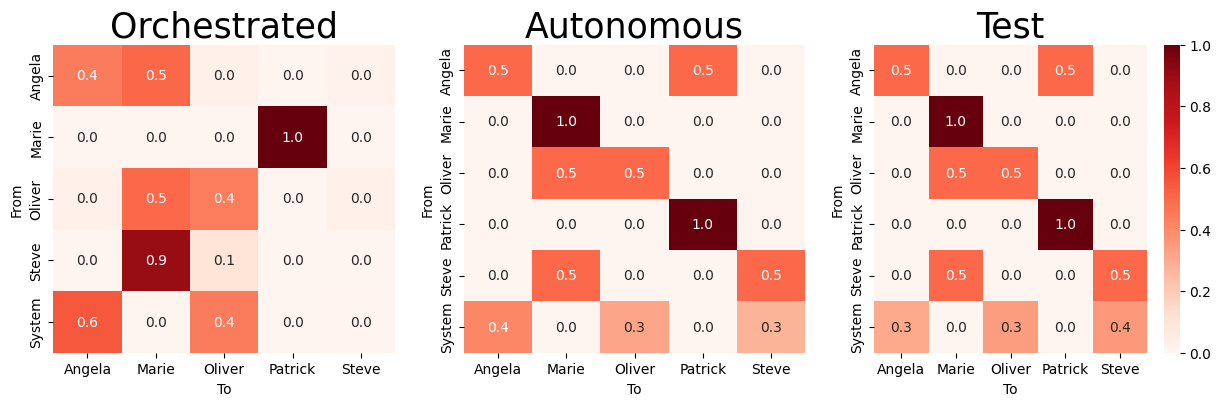

In [74]:
resource_handover_heatmap_3([log_orch, log_auto, log_test])